# Calibration

## Notebook setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import os

### Import data

In [2]:
def load_df(dir_path):
    """
    Load all CSV files in the specified directory into a single pandas DataFrame using a list comprehension.

    Args:
    dir_path (str): The path to the directory containing CSV files.

    Returns:
    pd.DataFrame: A DataFrame containing all the data from the CSV files.
    """
    # List comprehension to load each CSV file into a DataFrame if it ends with .csv
    dfs = [
        pd.read_csv(os.path.join(dir_path, f))
        for f in os.listdir(dir_path)
        if f.endswith(".csv")
    ]

    # Concatenate all DataFrames in the list into one DataFrame, if any are found
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

In [3]:
df = load_df("data")

# Clean up the column names that seem to have leading spaces
df.columns = df.columns.str.strip()

In [4]:
display(df.head(5))

,username,deviceName,position,distance,timestamp,targetPointX,targetPointY,gazePointX,gazePointY,faceTransform_0_x,...,leftEyeTransform_1_z,leftEyeTransform_1_w,leftEyeTransform_2_x,leftEyeTransform_2_y,leftEyeTransform_2_z,leftEyeTransform_2_w,leftEyeTransform_3_x,leftEyeTransform_3_y,leftEyeTransform_3_z,leftEyeTransform_3_w
0,victor,iPad Mini 6th,Middle,Regular,1.714394e+09,0.0,0.0,83.689627,256.625225,0.997560,...,0.234776,0.0,-0.130597,-0.232765,0.963724,0.0,0.031385,0.030332,0.025511,1.0
1,victor,iPad Mini 6th,Middle,Regular,1.714394e+09,0.0,0.0,84.011670,257.318690,0.997568,...,0.234554,0.0,-0.130562,-0.232547,0.963782,0.0,0.031385,0.030332,0.025511,1.0
2,victor,iPad Mini 6th,Middle,Regular,1.714394e+09,0.0,0.0,84.111527,257.091938,0.997556,...,0.234541,0.0,-0.130431,-0.232537,0.963802,0.0,0.031385,0.030332,0.025511,1.0
3,victor,iPad Mini 6th,Middle,Regular,1.714394e+09,0.0,0.0,84.108718,257.297939,0.997559,...,0.234492,0.0,-0.130513,-0.232487,0.963803,0.0,0.031385,0.030332,0.025511,1.0
4,victor,iPad Mini 6th,Middle,Regular,1.714394e+09,0.0,0.0,83.881667,257.637326,0.997553,...,0.234348,0.0,-0.130575,-0.232342,0.963830,0.0,0.031385,0.030332,0.025511,1.0


## Visualization

### Setup

In [5]:
# Identify unique target points and assign colors
unique_targets = (
    df[["targetPointX", "targetPointY"]].drop_duplicates().reset_index(drop=True)
)

colors = colormaps["tab10"]

### Global

Let's do a first visualization of the data.
We will show every target points with their corresponding computed gaze points.

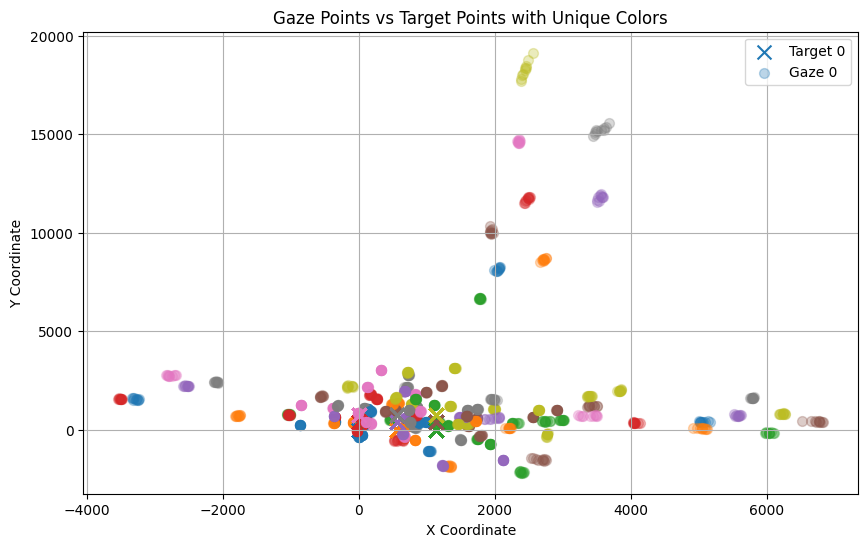

In [6]:
# Create a color dictionary for each target point
color_dict = {tuple(row): colors(i) for i, row in enumerate(unique_targets.to_numpy())}

# Plotting the data
plt.figure(figsize=(10, 6))

# Plot each target and corresponding gaze points with the same color
for idx, row in df.iterrows():
    target = (row["targetPointX"], row["targetPointY"])
    plt.scatter(
        row["targetPointX"],
        row["targetPointY"],
        color=color_dict[target],
        label=f"Target {idx}" if idx == 0 else "",
        s=100,
        marker="x",
    )
    plt.scatter(
        row["gazePointX"],
        row["gazePointY"],
        color=color_dict[target],
        alpha=0.3,
        label=f"Gaze {idx}" if idx == 0 else "",
        s=50,
        marker="o",
    )

# Adding labels and title
plt.title("Gaze Points vs Target Points with Unique Colors")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()

plt.grid(True)
plt.show()

Not much can be seen on this plot, as it is too cluttered.
Nonetheless, we can see that a shape is formed by the gaze points.

### In detail

Not let's explore the data in more detail.
We will plot the result for each target point separately.
In addition, we will plot the gaze points differently depending on the distance and head position at the time the point was recorded.

In [7]:
# Define colors for each position
positions = df["position"].unique()
color_dict = {pos: colors(i) for i, pos in enumerate(positions)}

# Define marker shapes for each distance
distances = df["distance"].unique()
markers = ["o", "s", "^"]  # Circle, Square, Triangle
marker_dict = {dist: markers[i] for i, dist in enumerate(distances)}

In [8]:
def show_subplots(with_limits=False, xlim=[-100, 1233], ylim=[-100, 844]):
    # Create a figure and a set of subplots in a 3x3 grid
    fig, axs = plt.subplots(3, 3, figsize=(20, 15))
    axs = axs.flatten()

    # Track legend handles and labels
    handles, labels = [], []

    # Plot each target point on a separate subplot
    for idx, (ax, (x, y)) in enumerate(zip(axs, unique_targets.to_numpy())):
        current_data = df[(df["targetPointX"] == x) & (df["targetPointY"] == y)]

        # Plot each combination of position and distance
        for (pos, dist), group_data in current_data.groupby(["position", "distance"]):
            handle = ax.scatter(
                group_data["gazePointX"],
                group_data["gazePointY"],
                color=color_dict[pos],
                marker=marker_dict[dist],
                label=f"Pos: {pos}, Dist: {dist}",
                s=50,
            )
            if idx == 0:  # Only add to legend once
                handles.append(handle)
                labels.append(f"Pos: {pos}, Dist: {dist}")

        # Plot target point
        ax.scatter(x, y, color="black", label="Target Point", s=100, marker="x")
        ax.set_title(f"Target Point at ({x}, {y})")
        ax.set_xlabel("X Coordinate")
        ax.set_ylabel("Y Coordinate")
        if with_limits:
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)

        ax.grid(True)

    # Hide unused axes if there are fewer than 9 targets
    for i in range(len(unique_targets), 9):
        axs[i].axis("off")

    # Add one legend to the figure
    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, 1))

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show plot
    plt.show()

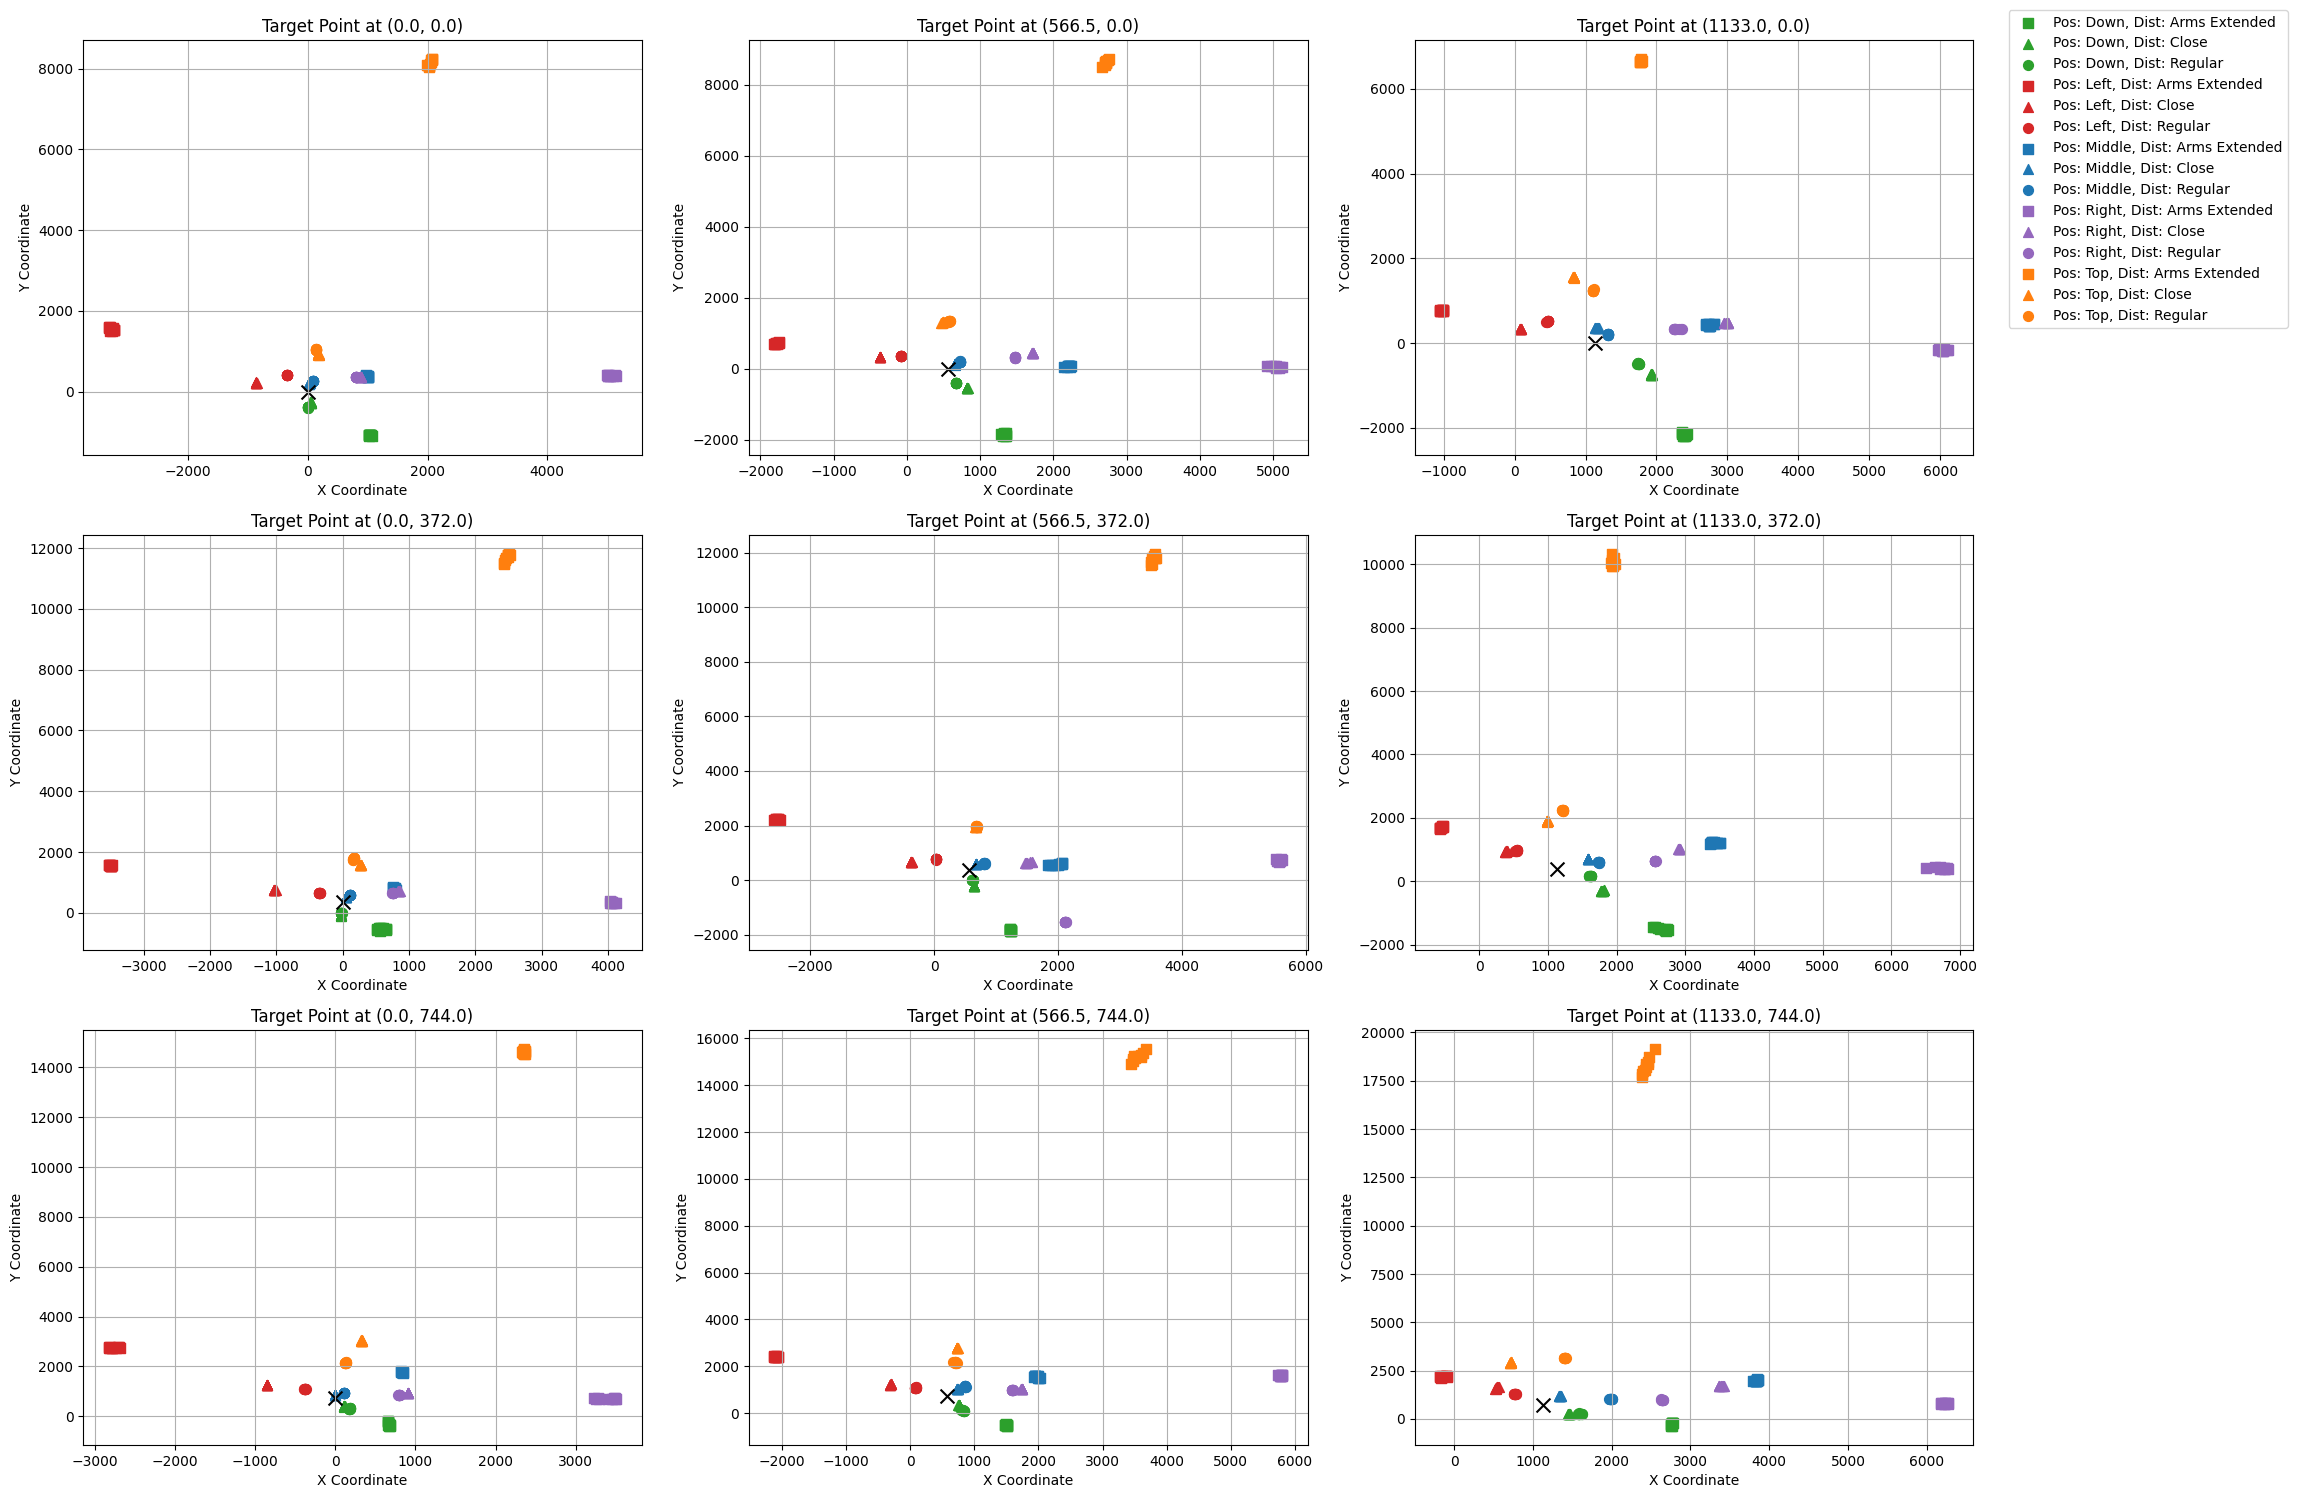

In [9]:
show_subplots()

Here again, we can see the same shape forming.
Now let's zoom in on the points at around the size of the ipad screen (± 100 points) before making any further analysis.

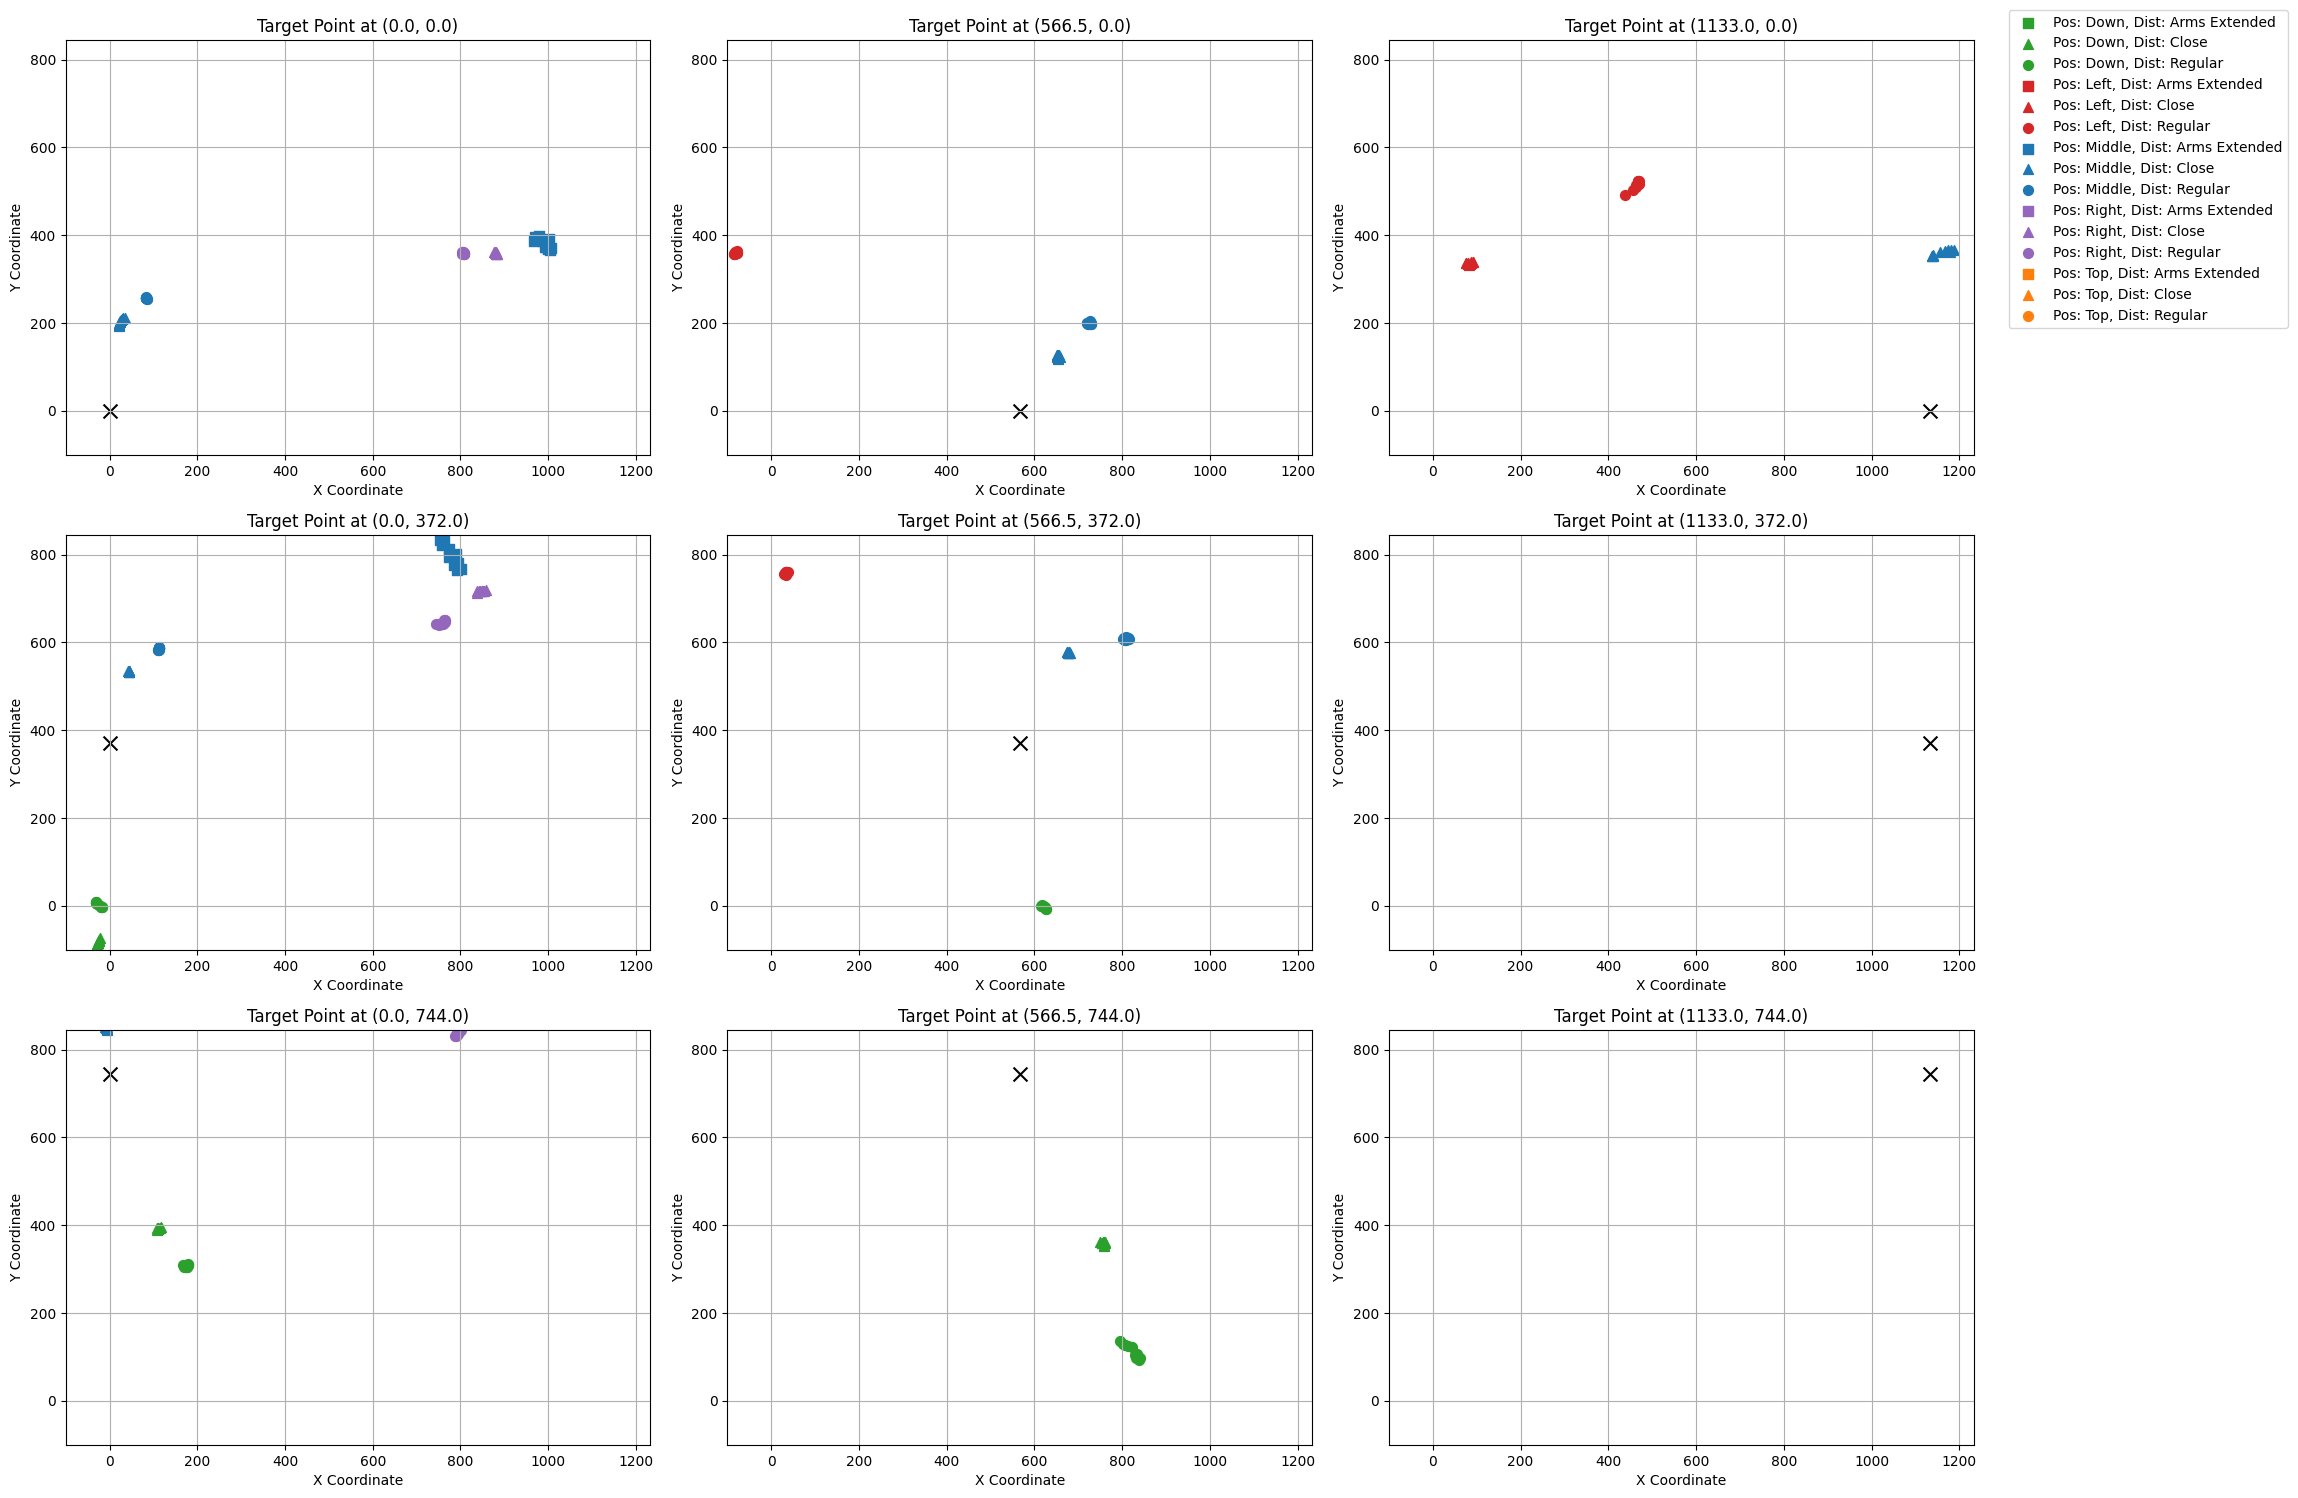

In [10]:
show_subplots(with_limits=True)

#### Analysis

The very first thing that jumps out is that the gaze points taken with the arms extended diverge a lot more to their respective target points than other ones.
Then, we can see that the head direction has a significant impact on the gaze points, as the points are directed the same way the head is facing.
It also make sense to see that the gaze points are more accurate when the head is facing the middle of the screen.
We can also see that the difference between being at a regular distance and being closer to the screen is not that significant.
Luckily, those setups are the most likely to happen in real life.